### EDA

In [54]:
!pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import tensorflow as tf
import transformers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
import wordcloud
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [56]:
# Load dataset
df = pd.read_csv('spam.csv', encoding = 'latin1')

# Map labels to integers
df['v1'] = df['v1'].map({'ham': 0, 'spam': 1})

# Verify the changes
print(df.head())

   v1                                                 v2 Unnamed: 2  \
0   0  Go until jurong point, crazy.. Available only ...        NaN   
1   0                      Ok lar... Joking wif u oni...        NaN   
2   1  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   0  U dun say so early hor... U c already then say...        NaN   
4   0  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [57]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Missing Values:
 v1    0
v2    0
dtype: int64
Label Distribution:
 0    4825
1     747
Name: v1, dtype: int64


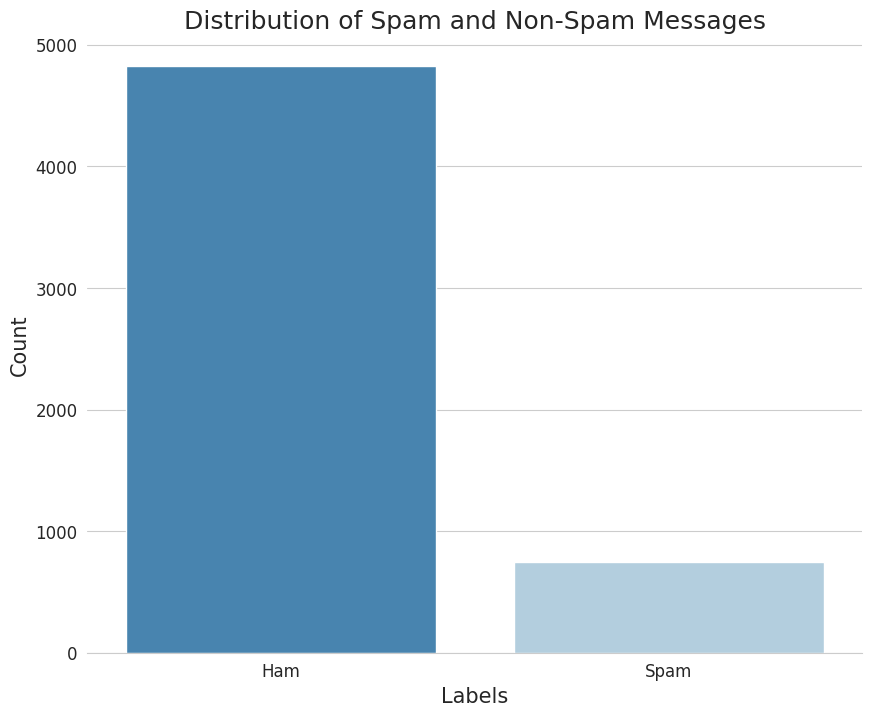

In [58]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

# Explore the distribution of labels
label_counts = df['v1'].value_counts()
print("Label Distribution:\n", label_counts)

# Plot the distribution of labels
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")  # Sets a white grid style for the background
sns.countplot(x='v1', data=df, palette="Blues_r")  # Using a reversed Blue palette
plt.title('Distribution of Spam and Non-Spam Messages', fontsize=18)
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks([0, 1], ['Ham', 'Spam'], fontsize=12)
plt.yticks(fontsize=12)
sns.despine(left=True)  # Removes the left border for cleaner look
plt.show()


count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64


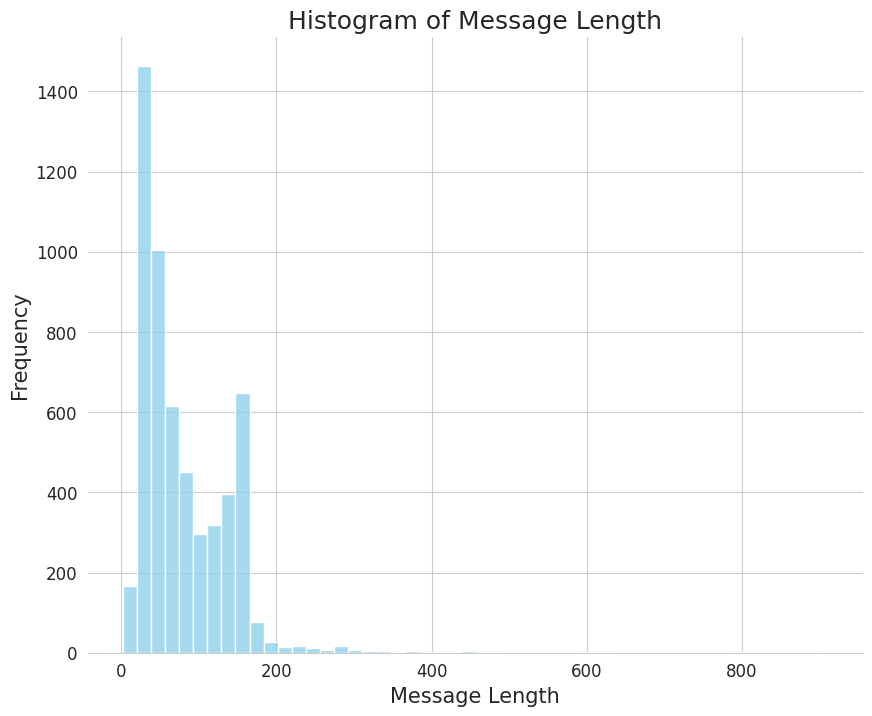

In [59]:
# Create a new feature for the length of each message
df['length'] = df['v2'].apply(len)

# Describe the new feature
print(df['length'].describe())

# Plot the distribution of message lengths
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")  # Sets a white grid style for the background
sns.histplot(df['length'], bins=50, color='skyblue')  # Histogram using seaborn
plt.title('Histogram of Message Length', fontsize=18)
plt.xlabel('Message Length', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine(left=True)  # Removes the left border for cleaner look
plt.show()

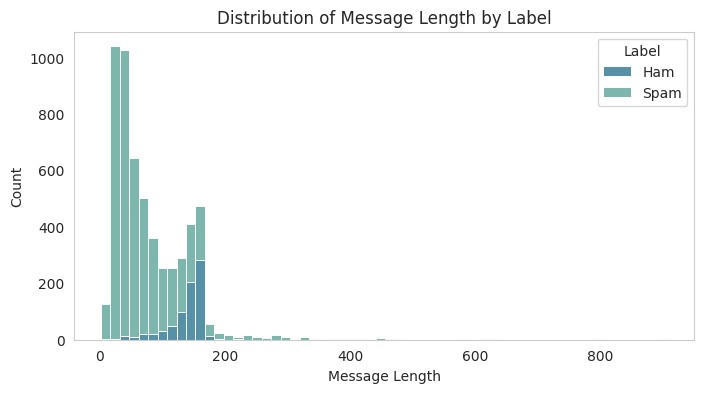

In [60]:
#Plot Distribution of Message Length by Label
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='length', hue='v1', bins=60, multiple='stack', palette='crest')

plt.xlim(-40, 950)
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.title('Distribution of Message Length by Label')
plt.legend(title='Label', labels=['Ham', 'Spam'])
plt.grid(False)

plt.show()

In [61]:
data_ham  = df[df['v1'] == 0].copy()
data_spam = df[df['v1'] == 1].copy()

In [62]:
def show_wordcloud(data_spam_or_ham, title):
    text = ' '.join(data_spam_or_ham['v2'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords, background_color='white',
                                        colormap='Blues', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10, 7), frameon=True)
    plt.imshow(fig_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

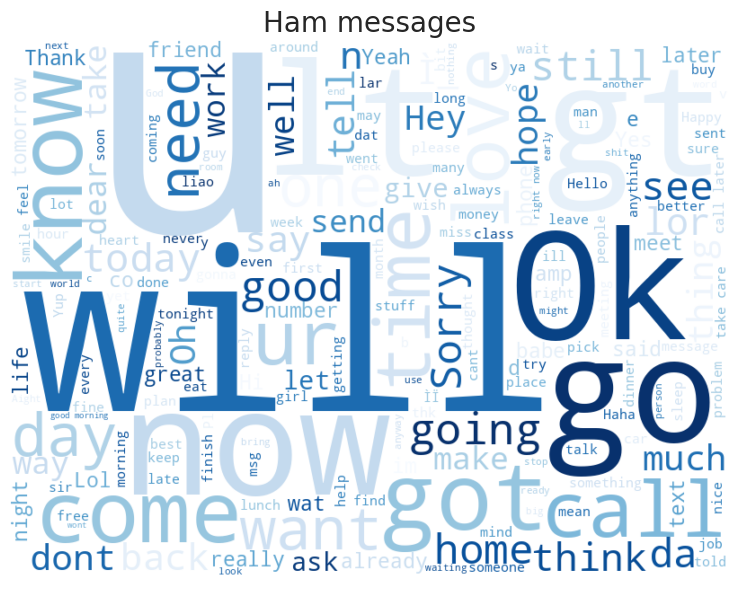

In [63]:
show_wordcloud(data_ham, "Ham messages")

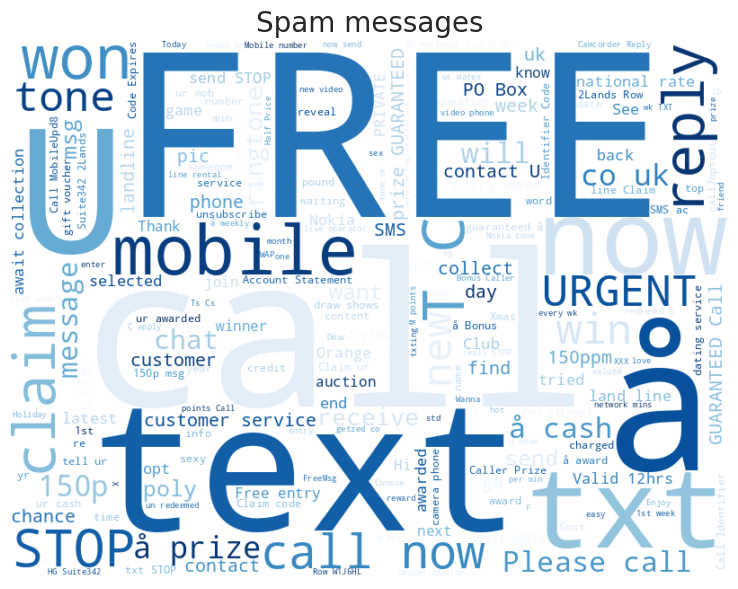

In [64]:
show_wordcloud(data_spam, "Spam messages")

### BERT Data Preparation

In [12]:
# Download necessary nltk data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Create a lemmatizer object
lemmatizer = WordNetLemmatizer()

# Define the stop words
stop_words = set(stopwords.words('english'))

# Define a function to clean and lemmatize text
def clean_text(text):
    text = text.lower()  # convert text to lower case
    text = nltk.word_tokenize(text)  # tokenize words
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words and word.isalpha()]  # lemmatize and remove stop words and non-alphabetic tokens
    text = ' '.join(text)  # join words back into text string
    return text

# Apply the clean_text function to the 'content' column
df['v2'] = df['v2'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [13]:
# Assuming 'df' is your original DataFrame

# Split the data into train and dev sets
X = df['v2']
y = df['v1']
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.4)

# Create df_train with train data
df_train = pd.DataFrame({'v2': X_train, 'v1': y_train})

# Create df_dev with dev data
df_dev = pd.DataFrame({'v2': X_dev, 'v1': y_dev})

In [14]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

DATA_COLUMN = 'v2'
LABEL_COLUMN = 'v1'


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(df_train, df_dev, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### BERT Model Evaluation

In [16]:
learning_rate = 1e-4  # Adjust the learning rate
batch_size = 64  # Adjust the batch size
num_epochs = 2 # Increase the number of epochs
clipnorm = 1.0  # Adjust the gradient clipping threshold

optimizer = Adam(learning_rate=learning_rate, clipnorm=clipnorm)
loss = SparseCategoricalCrossentropy(from_logits=True)
metrics = [SparseCategoricalAccuracy('accuracy')]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.fit(train_data, epochs=num_epochs, batch_size=batch_size, validation_data=validation_data)

Epoch 1/2
210/210 [==============================] - 277s 943ms/step - loss: 0.1462 - accuracy: 0.9539 - val_loss: 0.1039 - val_accuracy: 0.9785
Epoch 2/2
210/210 [==============================] - 187s 890ms/step - loss: 0.0697 - accuracy: 0.9828 - val_loss: 0.1409 - val_accuracy: 0.9637


In [17]:
model.save_pretrained('/content')

In [21]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Evaluate the model on the train and test data
train_eval_results = model.evaluate(train_data)
test_eval_results = model.evaluate(validation_data)

# Get the predicted labels for the train and test data
train_y_pred_logits = model.predict(train_data).logits
train_y_pred = tf.argmax(train_y_pred_logits, axis=1)

test_y_pred_logits = model.predict(validation_data).logits
test_y_pred = tf.argmax(test_y_pred_logits, axis=1)

# Convert the true labels to numpy array for train and test data
train_y_true = np.concatenate([y.numpy() for _, y in train_data])
test_y_true = np.concatenate([y.numpy() for _, y in validation_data])

70/70 [==============================] - 19s 277ms/step


Train Accuracy: 0.7606939874364343
Train Precision: 0.14621676891615543
Train Recall: 0.15748898678414097
Train F1-Score: 0.15164369034994699
Test Accuracy: 0.9636608344549125
Test Precision: 0.8173652694610778
Test Recall: 0.931740614334471
Test F1-Score: 0.8708133971291865


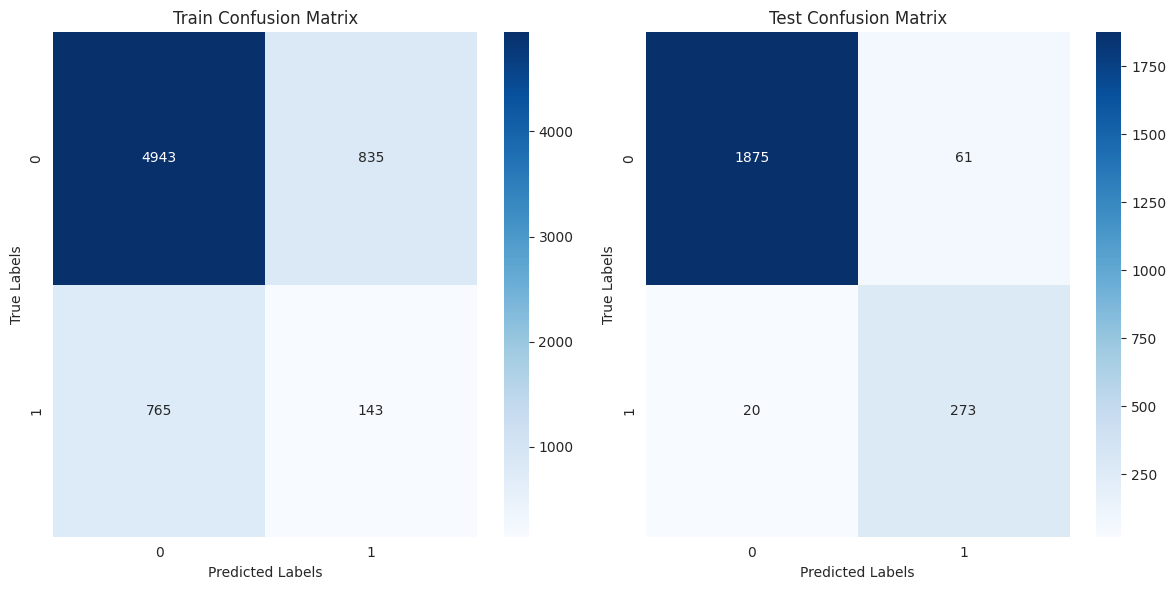

In [20]:
# Calculate additional evaluation metrics for train and test data
train_accuracy = accuracy_score(train_y_true, train_y_pred)
train_precision = precision_score(train_y_true, train_y_pred)
train_recall = recall_score(train_y_true, train_y_pred)
train_f1 = f1_score(train_y_true, train_y_pred)

test_accuracy = accuracy_score(test_y_true, test_y_pred)
test_precision = precision_score(test_y_true, test_y_pred)
test_recall = recall_score(test_y_true, test_y_pred)
test_f1 = f1_score(test_y_true, test_y_pred)

# Create confusion matrices for train and test data
train_confusion = confusion_matrix(train_y_true, train_y_pred)
test_confusion = confusion_matrix(test_y_true, test_y_pred)

# Print the evaluation metrics for train and test data
print("Train Accuracy:", train_accuracy)
print("Train Precision:", train_precision)
print("Train Recall:", train_recall)
print("Train F1-Score:", train_f1)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-Score:", test_f1)

# Display the confusion matrices for train and test data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(train_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Train Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(test_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix')

plt.tight_layout()
plt.show()



### CNN Data Preparation

In [65]:
# Load the SMS spam data
df = pd.read_csv('spam.csv', encoding='latin1')

# Preprocess the data
X = df['v2']  # SMS text
y = df['v1']  # Spam or ham label

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)

# Tokenize the text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

# Pad sequences
max_length = 128
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding='post')

# Convert labels to numeric format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

### CNN Model Evaluation

In [66]:
# Define the CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=10000, output_dim=300, input_length=max_length))
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model
cnn_history = cnn_model.fit(X_train_padded, y_train_encoded, epochs=2, validation_data=(X_val_padded, y_val_encoded))

# Evaluate the CNN model
cnn_eval_results = cnn_model.evaluate(X_val_padded, y_val_encoded)

# Print the evaluation metrics for the CNN model
print("CNN Accuracy:", cnn_eval_results[1])

Epoch 1/2
105/105 [==============================] - 23s 207ms/step - loss: 0.2766 - accuracy: 0.8998 - val_loss: 0.0946 - val_accuracy: 0.9749
Epoch 2/2
70/70 [==============================] - 0s 5ms/step - loss: 0.0546 - accuracy: 0.9816
CNN Accuracy: 0.981606125831604


In [67]:
cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 128, 300)          3000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 126, 64)           57664     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 3,057,729
Trainable params: 3,057,729
Non-trainable params: 0
_________________________________________________________________


70/70 [==============================] - 0s 2ms/step
Train Accuracy: 0.9970086748429554
Train Precision: 0.995475113122172
Train Recall: 0.9821428571428571
Train F1-Score: 0.9887640449438202
Test Accuracy: 0.9816061013907582
Test Precision: 0.9777777777777777
Test Recall: 0.882943143812709
Test F1-Score: 0.9279437609841827


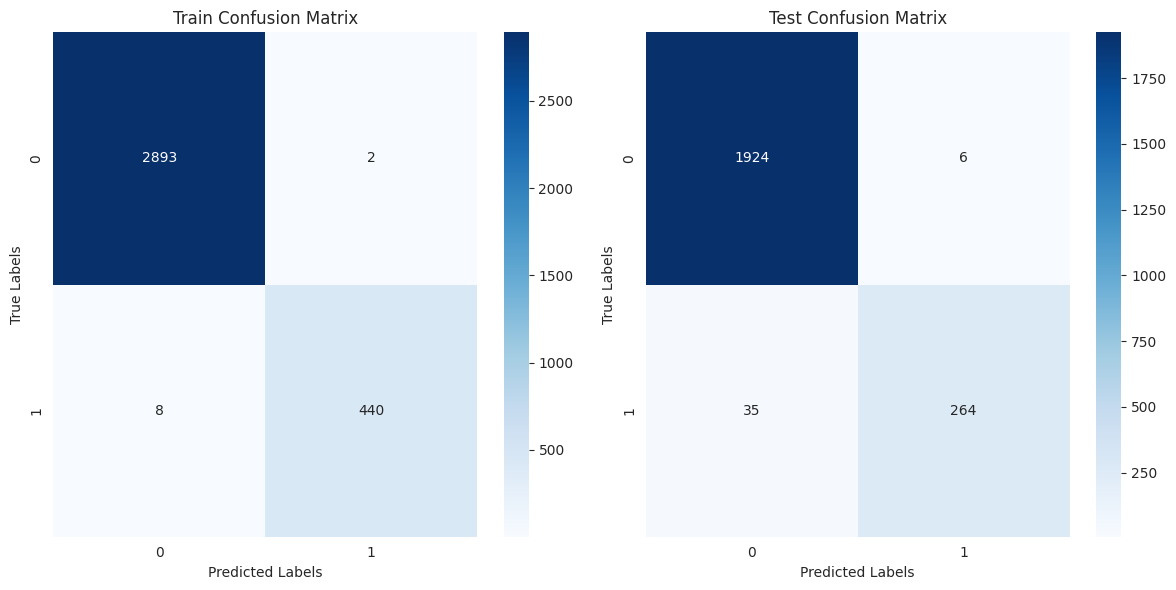

In [68]:
# Get the predicted labels for the train and test data using the CNN model
train_y_pred_probs = cnn_model.predict(X_train_padded)
train_y_pred = np.round(train_y_pred_probs).astype(int).flatten()

test_y_pred_probs = cnn_model.predict(X_val_padded)
test_y_pred = np.round(test_y_pred_probs).astype(int).flatten()

# Convert the true labels to numpy arrays for train and test data
train_y_true = np.array(y_train_encoded)
test_y_true = np.array(y_val_encoded)

# Calculate additional evaluation metrics for the train and test data
train_accuracy = accuracy_score(train_y_true, train_y_pred)
train_precision = precision_score(train_y_true, train_y_pred)
train_recall = recall_score(train_y_true, train_y_pred)
train_f1 = f1_score(train_y_true, train_y_pred)

test_accuracy = accuracy_score(test_y_true, test_y_pred)
test_precision = precision_score(test_y_true, test_y_pred)
test_recall = recall_score(test_y_true, test_y_pred)
test_f1 = f1_score(test_y_true, test_y_pred)

# Create confusion matrices for the train and test data
train_confusion = confusion_matrix(train_y_true, train_y_pred)
test_confusion = confusion_matrix(test_y_true, test_y_pred)

# Print the evaluation metrics for the train and test data
print("Train Accuracy:", train_accuracy)
print("Train Precision:", train_precision)
print("Train Recall:", train_recall)
print("Train F1-Score:", train_f1)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-Score:", test_f1)

# Display the confusion matrices for the train and test data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(train_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Train Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(test_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix')

plt.tight_layout()
plt.show()

### LSTM Model Evaluation

In [69]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=10000, output_dim=300, input_length=128))
lstm_model.add(LSTM(64, return_sequences=True)) # Add return_sequences=True to connect this LSTM to the next
lstm_model.add(LSTM(64))  # Another LSTM layer
lstm_model.add(Dense(64, activation='tanh'))  # Dense layer before output
lstm_model.add(Dense(1, activation='sigmoid'))  # Output layer

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 128, 300)          3000000   
                                                                 
 lstm_9 (LSTM)               (None, 128, 64)           93440     
                                                                 
 lstm_10 (LSTM)              (None, 64)                33024     
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 3,130,689
Trainable params: 3,130,689
Non-trainable params: 0
_________________________________________________________________


70/70 [==============================] - 1s 9ms/step
Train Accuracy: 0.8659886329644032
Train Precision: 0.0
Train Recall: 0.0
Train F1-Score: 0.0
Test Accuracy: 0.8654104979811574
Test Precision: 0.0
Test Recall: 0.0
Test F1-Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


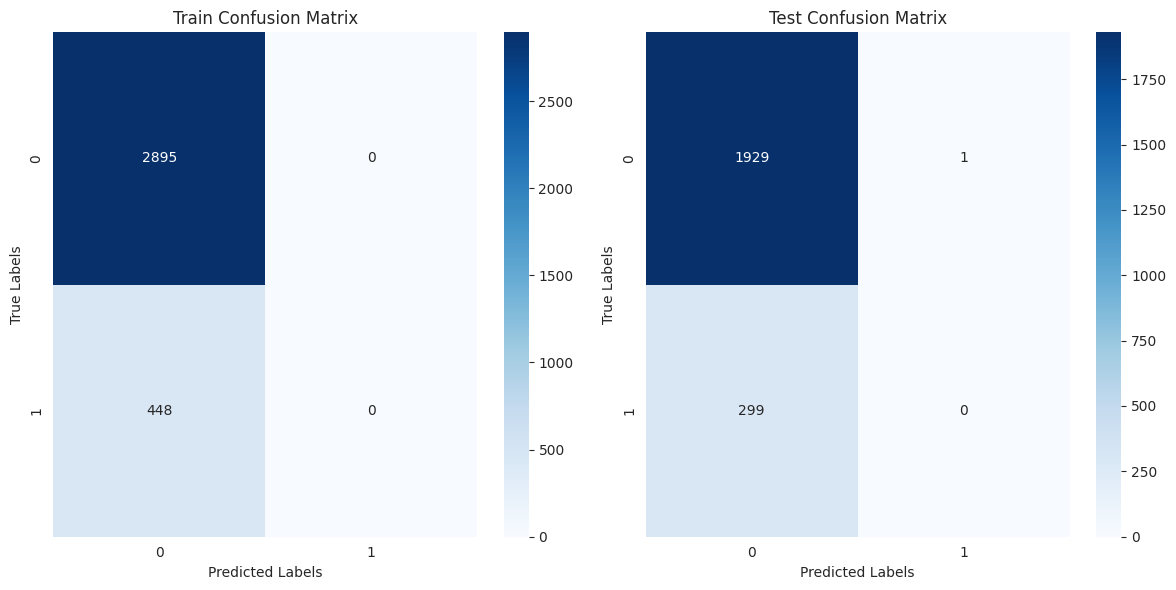

In [70]:
# Get the predicted labels for the train and test data using the CNN model

train_y_pred_probs = lstm_model.predict(X_train_padded)
train_y_pred = np.round(train_y_pred_probs).astype(int).flatten()

test_y_pred_probs = lstm_model.predict(X_val_padded)
test_y_pred = np.round(test_y_pred_probs).astype(int).flatten()

# Convert the true labels to numpy arrays for train and test data
train_y_true = np.array(y_train_encoded)
test_y_true = np.array(y_val_encoded)

# Calculate additional evaluation metrics for the train and test data
train_accuracy = accuracy_score(train_y_true, train_y_pred)
train_precision = precision_score(train_y_true, train_y_pred)
train_recall = recall_score(train_y_true, train_y_pred)
train_f1 = f1_score(train_y_true, train_y_pred)

test_accuracy = accuracy_score(test_y_true, test_y_pred)
test_precision = precision_score(test_y_true, test_y_pred)
test_recall = recall_score(test_y_true, test_y_pred)
test_f1 = f1_score(test_y_true, test_y_pred)

# Create confusion matrices for the train and test data
train_confusion = confusion_matrix(train_y_true, train_y_pred)
test_confusion = confusion_matrix(test_y_true, test_y_pred)

# Print the evaluation metrics for the train and test data
print("Train Accuracy:", train_accuracy)
print("Train Precision:", train_precision)
print("Train Recall:", train_recall)
print("Train F1-Score:", train_f1)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-Score:", test_f1)

# Display the confusion matrices for the train and test data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(train_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Train Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(test_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix')

plt.tight_layout()
plt.show()

### LSTM overfitting

In [71]:

# Load the SMS spam data
df = pd.read_csv('spam.csv', encoding='latin1')

df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)

# Drop any missing values
df.dropna(inplace=True)

# Preprocess the data
X = df['v2']  # SMS text
y = df['v1']  # Spam or ham label

# Convert labels to numeric format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.4, random_state=42)

# Combine the training data into a single DataFrame for easier manipulation
train_df = pd.DataFrame({'text': X_train, 'label': y_train})

# Separate minority and majority classes
spam = train_df[train_df['label'] == 1]  # spam is labeled as 1
ham = train_df[train_df['label'] == 0]   # ham is labeled as 0

# Upsample minority
spam_upsampled = spam.sample(len(ham), replace=True)

# Combine majority and upsampled minority
upsampled = pd.concat([ham, spam_upsampled])

# Shuffle the data to prevent any patterns that might emerge
upsampled = upsampled.sample(frac=1, random_state=42)

# Now separate the labels and the text
X_train_resampled = upsampled['text']
y_train_resampled = upsampled['label']

# Tokenize the text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train_resampled)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train_resampled)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

# Pad sequences
max_length = 128
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding='post')


70/70 [==============================] - 1s 9ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 0.5
Train Precision: 0.0
Train Recall: 0.0
Train F1-Score: 0.0
Test Accuracy: 0.8654104979811574
Test Precision: 0.0
Test Recall: 0.0
Test F1-Score: 0.0


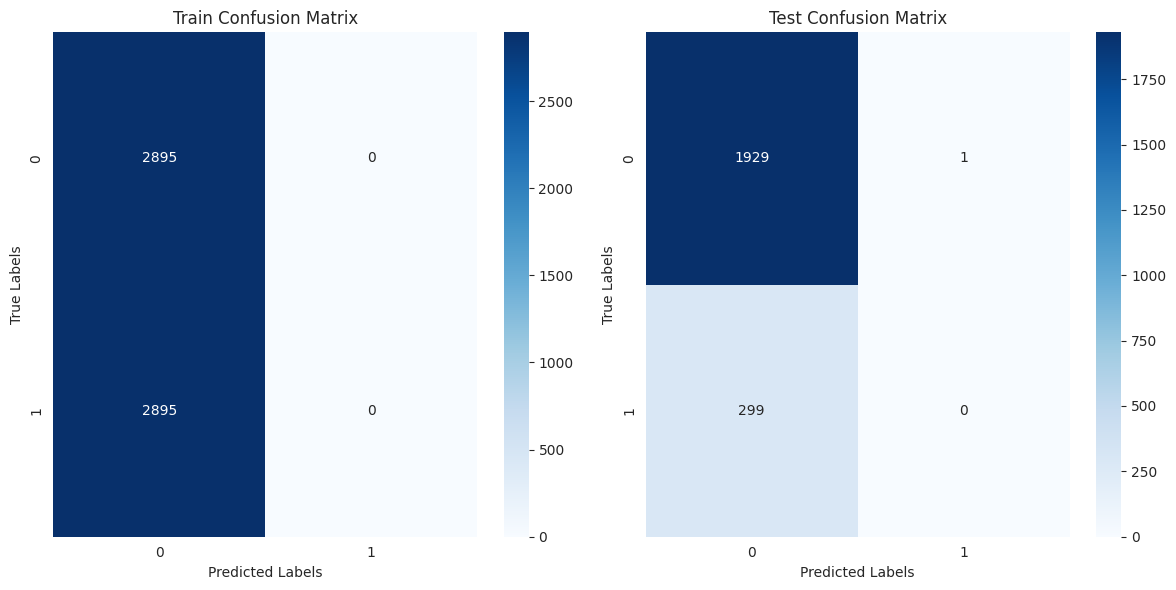

In [72]:
train_y_pred_probs = lstm_model.predict(X_train_padded)
train_y_pred = np.round(train_y_pred_probs).astype(int).flatten()

test_y_pred_probs = lstm_model.predict(X_val_padded)
test_y_pred = np.round(test_y_pred_probs).astype(int).flatten()

# Convert the true labels to numpy arrays for train and test data
train_y_true = np.array(y_train_resampled)
test_y_true = np.array(y_val_encoded)

# Calculate additional evaluation metrics for the train and test data
train_accuracy = accuracy_score(train_y_true, train_y_pred)
train_precision = precision_score(train_y_true, train_y_pred)
train_recall = recall_score(train_y_true, train_y_pred)
train_f1 = f1_score(train_y_true, train_y_pred)

test_accuracy = accuracy_score(test_y_true, test_y_pred)
test_precision = precision_score(test_y_true, test_y_pred)
test_recall = recall_score(test_y_true, test_y_pred)
test_f1 = f1_score(test_y_true, test_y_pred)

# Create confusion matrices for the train and test data
train_confusion = confusion_matrix(train_y_true, train_y_pred)
test_confusion = confusion_matrix(test_y_true, test_y_pred)

# Print the evaluation metrics for the train and test data
print("Train Accuracy:", train_accuracy)
print("Train Precision:", train_precision)
print("Train Recall:", train_recall)
print("Train F1-Score:", train_f1)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-Score:", test_f1)

# Display the confusion matrices for the train and test data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(train_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Train Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(test_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Confusion Matrix')

plt.tight_layout()
plt.show()